In [1]:
import torch, torchvision, numpy, pandas
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
transfrom = torchvision.transforms.Lambda(lambda x : torchvision.transforms.functional.to_tensor(x).to(device))
target_transform=torchvision.transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1).to(device))
tr_data = torchvision.datasets.MNIST(".", True, transfrom, target_transform, download=False)
te_data = torchvision.datasets.MNIST(".", False, transfrom, target_transform, download=False)

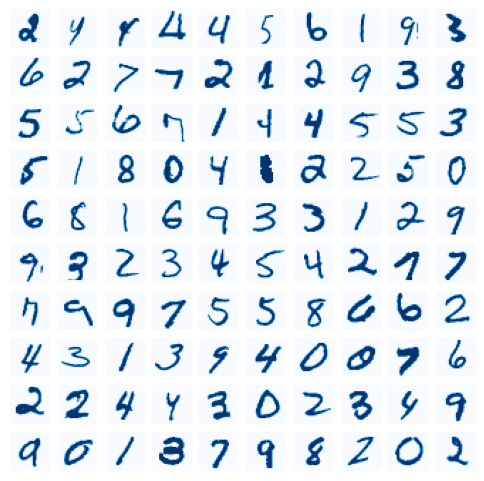

In [4]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(tr_data), size=(1,)).item()
    img, label = tr_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.cpu().squeeze(), cmap="Blues")
plt.show()

In [5]:
class CnnModule(torch.nn.Module):
    def __init__(self, device=torch.device('cpu')):
        super().__init__()
        self.layers_encode = torch.nn.Sequential(
            torch.nn.Conv2d(1, 14, kernel_size=5, stride=1, padding=2, device=device),
            torch.nn.ReLU(),
            torch.nn.Conv2d(14, 7, kernel_size=5, stride=1, padding=2, device=device),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(7*28*28, 28, device=device),
            torch.nn.ReLU(),
        )
        self.layers_decode = torch.nn.Sequential(
            torch.nn.Linear(28, 7*28*28, device=device),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (7, 28, 28)),
            torch.nn.Conv2d(7, 14, kernel_size=5, stride=1, padding=2, device=device),
            torch.nn.ReLU(),
            torch.nn.Conv2d(14, 1, kernel_size=5, stride=1, padding=2, device=device),
            torch.nn.ReLU(),
        )

        for seq in (self.layers_encode, self.layers_decode):
            for layer in seq:
                for name, param in layer.named_parameters():
                    if name == "weight":
                        torch.nn.init.xavier_normal_(param)
                    elif name == "bias":
                        torch.nn.init.zeros_(param)

    def forward(self, inputs):
        a = self.layers_encode(inputs)
        b = self.layers_decode(a)
        return b, a

    def forward_as_numpy(self, inputs):
        prev, feature = self.forward(inputs)
        return prev.cpu().detach().numpy(), feature.cpu().detach().numpy()

    def train(self, epochs, batch_size, loss_fn, optimizer, train_dataset, test_dataset=None):
        dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        if test_dataset:
            te_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        for epoch in range(1, epochs+1):
            size, total_loss = 0, 0
            for batch, (x, y) in enumerate(dataloader):
                pred, _ = self.forward(x)
                loss = loss_fn(pred, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                size += len(x)
                total_loss += loss.item() * len(x)
            print(f"[{epoch}] train_loss:{(total_loss/size):<5f}")

            if test_dataset:
                size, total_loss = 0, 0
                for batch, (x, y) in enumerate(te_dataloader):
                    with torch.no_grad():
                        pred, _ = self.forward(x)
                        loss = loss_fn(pred, x)
                        
                        size += len(x)
                        total_loss += loss.item() * len(x)
                print(f"[{epoch}] test_loss:{(total_loss/size):<5f}")

In [6]:
module = CnnModule(device=device)

In [7]:
module.train(
    epochs = 30,
    batch_size = 32,
    loss_fn = torch.nn.MSELoss(),
    optimizer = torch.optim.SGD(module.parameters(), lr=0.05, momentum=0.9),
    train_dataset = tr_data,
    test_dataset = te_data,
)

[1] train_loss:0.027727
[1] test_loss:0.012491
[2] train_loss:0.011004
[2] test_loss:0.009821
[3] train_loss:0.009648
[3] test_loss:0.008915
[4] train_loss:0.008849
[4] test_loss:0.008217
[5] train_loss:0.008175
[5] test_loss:0.007788
[6] train_loss:0.007701
[6] test_loss:0.007387
[7] train_loss:0.007372
[7] test_loss:0.007146
[8] train_loss:0.007095
[8] test_loss:0.006858
[9] train_loss:0.006880
[9] test_loss:0.006613
[10] train_loss:0.006705
[10] test_loss:0.006532
[11] train_loss:0.006546
[11] test_loss:0.006411
[12] train_loss:0.006419
[12] test_loss:0.006272
[13] train_loss:0.006298
[13] test_loss:0.006158
[14] train_loss:0.006208
[14] test_loss:0.006182
[15] train_loss:0.006112
[15] test_loss:0.006095
[16] train_loss:0.006031
[16] test_loss:0.005946
[17] train_loss:0.005956
[17] test_loss:0.005880
[18] train_loss:0.005895
[18] test_loss:0.005851
[19] train_loss:0.005831
[19] test_loss:0.005805
[20] train_loss:0.005769
[20] test_loss:0.005741
[21] train_loss:0.005726
[21] test_los

In [8]:
reconstructed_images, image_representations = module.forward_as_numpy(torch.cat([x for x, y in te_data]).view(-1, 1, 28, 28))

In [9]:
numpy.random.seed(20250101)
a = numpy.random.randint(0, 10000)

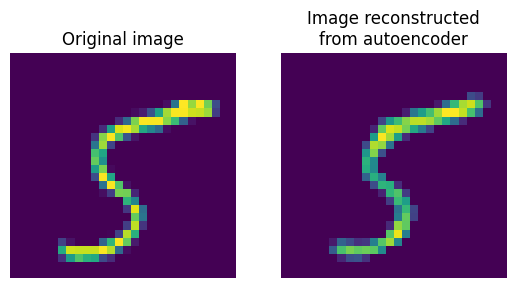

In [10]:
def display_image(ax, t):
    ax.imshow(t.reshape(28, 28))

f, axarr = plt.subplots(1,2)
display_image(axarr[0], te_data[a][0].cpu().detach().numpy())
display_image(axarr[1], reconstructed_images[a])

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

In [11]:
tsne = TSNE(n_components=2, perplexity=30.0, init='random', random_state=20250101)
tsne_result = tsne.fit_transform(image_representations)

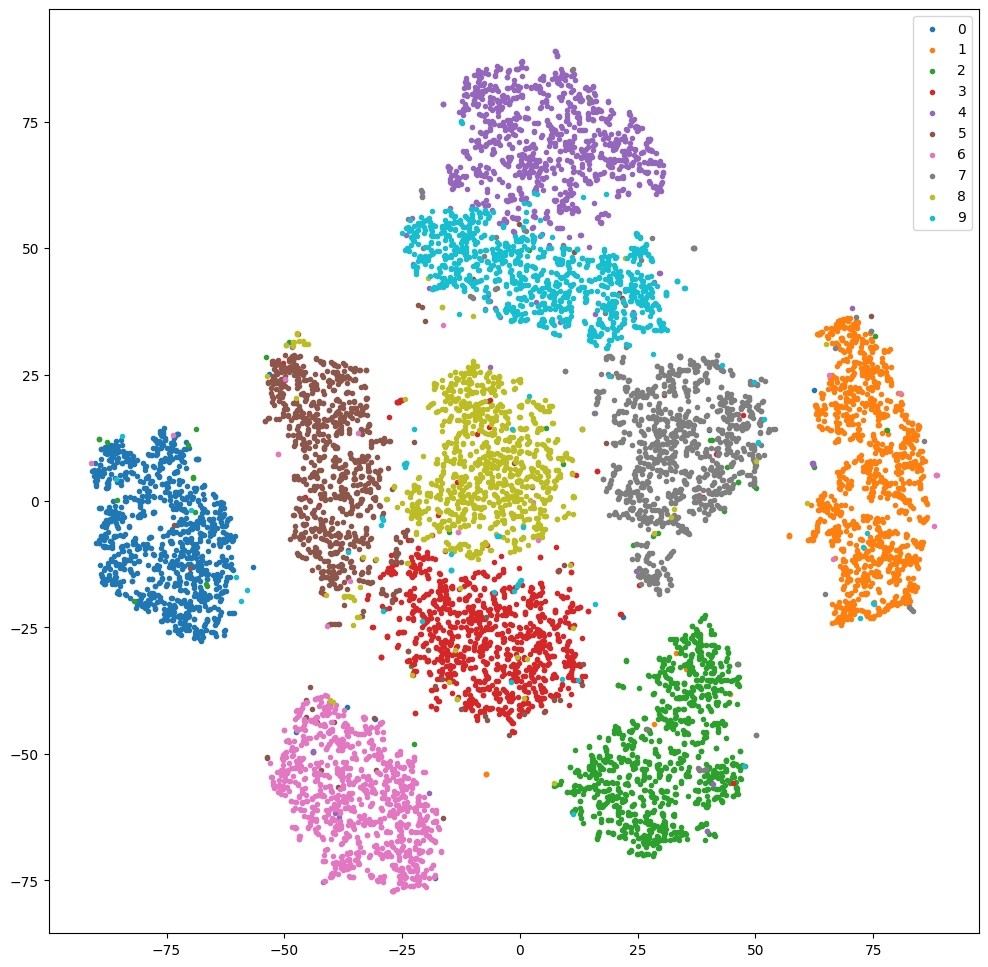

In [12]:
tsne_df = pandas.DataFrame({
    'tsne_dim_1': tsne_result[:,0],
    'tsne_dim_2': tsne_result[:,1],
    'category': te_data.targets
})
groups = tsne_df.groupby('category')

# Plot
fig, ax = plt.subplots(figsize=(12,12))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for idx, (name, group) in enumerate(groups):
    ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker='.', label=name)
ax.legend()